# Retraining MobileNet SSD v2 model using tenser flow 2 and object detection API

In this notebook, you will make a new neural network. Before executiong it, make sure you followed all the instructions on the `README.md` file.

## *How to use:*

Some cells need to be modified for your specific data base or for whatever customization you might see fit. Before executing this file, read it thoroughly and search for warnings on where to change what for a custom data base.

After modifying everything that is needed, execute each cell in order. Some cells might have other instructions for you to follow outside the notebook, so be alert.

All cells that require modifications will be flagged with a `# -!-` at the very beginning of it.

## *Structure:*

When executing the cells, two folders will be created with it. One is a folder where the images for testing the model would be downloaded into and the other one is a git repository that contains most of the external files we need. It also contains our workspace. It will be explained further in the notebook.

## *Dataset:*

Also important before executing this file is to have your data set made with the *PASCAL VOC* format inside the `dataset` folder.

Your dataset needs also to be separated into `test` and `train` folders, like the example bellow.

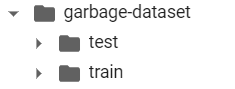

We recommend puting only up to 20% of your dataset into the `test` folder. The rest goes into the `train`folder.

### Resources Used
- TFRecord Generator
    - https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py

# 0. Setup Paths and some configs

In [7]:
!git clone https://github.com/pfeinsper/RealTimeObjectDetection.git

Cloning into 'RealTimeObjectDetection'...


After executing this first cell, take some time to read the structure of the cloned repository.

To facilitate a bit, here is a brief explanation

```
RealTimeObjectDetection/Tensorflow
|- scripts
|   |- *some scripts used here*
|
|- workspace
    |- annotations
    |- exported_models
    |- images_for_testing
    |- models 
    |- pre-trained-models
        |- *Pre trained model we will use*

```


Chance the bellow cell `DATASET_NAME` variable to match the folder of your dataset inside the `dataset` folder.

In [8]:
# -!-

DATASET_NAME = 'mc-dataset'  # change this one

WORKSPACE_PATH = 'RealTimeObjectDetection/Tensorflow/workspace'
SCRIPTS_PATH = 'RealTimeObjectDetection/Tensorflow/scripts'

ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = 'dataset/' + DATASET_NAME
MODEL_PATH = WORKSPACE_PATH+'/models'

PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'

# 1. Create Label Map
First thing to change for the custom dataset is the label map. Change the variable *labels* in the *Create label map* section to corespond your labes.

Example: 

```python
labels = [{'name':'object_1', 'id':1}, {'name':'object_2', 'id':2}]
```

In [27]:
# -!-

labels = [{'name':"McDonald's logo", 'id':1}] # change here
NUM_OF_CLASSES = len(labels)

with open(ANNOTATION_PATH + '/label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\"{}\"\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [10]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/test' } -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record' }

Successfully created the TFRecord file: RealTimeObjectDetection/Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: RealTimeObjectDetection/Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

you can change the name of your new model bellow

In [11]:
# -!-

CUSTOM_MODEL_NAME = 'custom_MCdonald_model' 

In [12]:
CHECKPOINT_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME

In [13]:
%%bash -s "$CUSTOM_MODEL_NAME"

mkdir RealTimeObjectDetection/Tensorflow/workspace/models/$1
cp RealTimeObjectDetection/Tensorflow/workspace//pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config RealTimeObjectDetection/Tensorflow/workspace/models/$1

# 5. Update Config For Transfer Learning

In [14]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format


CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'


config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)


pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  


pipeline_config.model.ssd.num_classes = NUM_OF_CLASSES
pipeline_config.train_config.batch_size = 4  # can be changed, but no need

pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"

pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'

pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']


config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   


pipeline_config

model {
  ssd {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
 

# 6. Train the model

In [15]:
TRAIN_STEPS = 1000  # <- you can change the number of steps to increase precision
PRETRAINED_MODEL_DIR = '/content/RealTimeObjectDetection/Tensorflow/workspace/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'

In [16]:
print(f'python3 ../models/research/object_detection/model_main_tf2.py --model_dir={CHECKPOINT_PATH} --pipeline_config_path={CONFIG_PATH} --num_train_steps={TRAIN_STEPS}')

python3 ../models/research/object_detection/model_main_tf2.py --model_dir=RealTimeObjectDetection/Tensorflow/workspace/models/custom_MCdonald_model --pipeline_config_path=RealTimeObjectDetection/Tensorflow/workspace/models/custom_MCdonald_model/pipeline.config --num_train_steps=1000


***Important*** - The above cell gives you a line of command to be executed (copied and pasted) directly into a terminal. This terminal must be inside this `Transfer Learning` directory. 

Once in executions, you will see some files appearing inside the `workpace/models/*your model's name*` folder. Those represent the checkpoints of the training.

***Wait the execution to proceed***

# 7. Testing the model

## 7.1 Download some images for testing the new model

In the cell below, change the link of the image for testing in the last line for one that makes sense for testing your new model.

In [17]:
%%bash
cd RealTimeObjectDetection/Tensorflow/workspace/images_for_testing
wget http://f.i.uol.com.br/agora/galeria/images/13285393.jpeg # <-- link to img for testing - copy and paste the link for a google image here to be tested

--2021-11-24 14:34:50--  http://f.i.uol.com.br/agora/galeria/images/13285393.jpeg
Resolving f.i.uol.com.br (f.i.uol.com.br)... 200.147.4.56, 2804:49c:3102:405:ffff:ffff:ffff:7, 2804:49c:3101:405:ffff:ffff:ffff:20, ...
Connecting to f.i.uol.com.br (f.i.uol.com.br)|200.147.4.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20449 (20K) [image/jpeg]
Saving to: ‘13285393.jpeg’

     0K .......... .........                                  100% 3.07M=0.006s

2021-11-24 14:34:51 (3.07 MB/s) - ‘13285393.jpeg’ saved [20449/20449]



## 7.2 Export checkpoints and config into new model and test with downloaded images

In [18]:
%%bash -s "$CUSTOM_MODEL_NAME"
mkdir RealTimeObjectDetection/Tensorflow/workspace/exported_models/$1

In [28]:
print(f'python3 ../models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path {CONFIG_PATH} --trained_checkpoint_dir {CHECKPOINT_PATH} --output_directory RealTimeObjectDetection/Tensorflow/workspace/exported_models/{CUSTOM_MODEL_NAME}')

python3 ../models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path RealTimeObjectDetection/Tensorflow/workspace/models/custom_MCdonald_model/pipeline.config --trained_checkpoint_dir RealTimeObjectDetection/Tensorflow/workspace/models/custom_MCdonald_model --output_directory RealTimeObjectDetection/Tensorflow/workspace/exported_models/custom_MCdonald_model


***Reminder*** - Again, this cell above gives you a command to be executed inside a terminal. Execute ir the same way you did the last one.

***Wait the execution to proceed***

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse

def detect_image(IMAGE_PATHS):

    """
    Object Detection (On Image) From TF2 Saved Model
    =====================================
    """

    # Enable GPU dynamic memory allocation
    gpus = tf.config.experimental.list_physical_devices('GPU')
    # for gpu in gpus:
    #     tf.config.experimental.set_memory_growth(gpu, True)

    # PROVIDE PATH TO MODEL DIRECTORY
    PATH_TO_MODEL_DIR = f'RealTimeObjectDetection/Tensorflow/workspace/exported_models/{CUSTOM_MODEL_NAME}'

    # PROVIDE PATH TO LABEL MAP
    PATH_TO_LABELS = 'RealTimeObjectDetection/Tensorflow/workspace/annotations/label_map.pbtxt'

    # PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
    MIN_CONF_THRESH = float(0.60)

    # LOAD THE MODEL

    import time
    from object_detection.utils import label_map_util
    from object_detection.utils import visualization_utils as viz_utils

    PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

    print('Loading model...', end='')
    start_time = time.time()

    # LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
    detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Done! Took {} seconds'.format(elapsed_time))

    # LOAD LABEL MAP DATA FOR PLOTTING

    category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                      use_display_name=True)

    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

    def load_image_into_numpy_array(path):
        """Load an image from file into a numpy array.
        Puts image into numpy array to feed into tensorflow graph.
        Note that by convention we put it into a numpy array with shape
        (height, width, channels), where channels=3 for RGB.
        Args:
        path: the file path to the image
        Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
        """
        return np.array(Image.open(path))




    print('Running inference for {}... '.format(IMAGE_PATHS), end='')

    image = cv2.imread(IMAGE_PATHS)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_with_detections = image.copy()

    # SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.5,
        agnostic_mode=False)

    print('Done')
    # DISPLAYS OUTPUT IMAGE
    cv2.imshow('detect', image_with_detections)
    # CLOSES WINDOW ONCE KEY IS PRESSED
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [26]:
detect_image('RealTimeObjectDetection/Tensorflow/workspace/images_for_testing/13285393.jpeg')

Loading model...Done! Took 8.00803017616272 seconds
Running inference for RealTimeObjectDetection/Tensorflow/workspace/images_for_testing/13285393.jpeg... Done


# Wraping up

Congratulation! Now you have a working model that detects what you want.

You can proceed by testing it with a webcam with the `detect_webcam_transfer.py` script. Don't forget to change the PATHs!